# Прогнозирование оттока клиентов сети фитнес-центров.

## Общие положения. <a id="step1"></a>    

**Заказчик** — отдел по работе с клиентами фитнес-центра.

**Цель исследования** - спрогнозировать вероятность оттока для каждого клиента; сформировать типичные портреты клиентов; проанализировать основные признаки, наиболее сильно влияющие на отток; разработать рекомендации по повышению качества работы с клиентами. 

**Исходные данные** — обезличенные данные анкет клиентов, данные об абонементах и посещениях фитнес-центра.

**Основные шаги:**

1. [Общие положения.](#step1)
2. [Изучение общей информации из файлов.](#step2)
3. [Исследовательский анализ данных (EDA).](#step3)
4. [Построение модели прогнозирования оттока клиентов.](#step4)
5. [Кластеризация клиентов.](#step5)
6. [Выводы и рекомендации.](#step6)

## Изучение общей информации из файлов. <a id="step2"></a>    

### Получение данных

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, silhouette_score

import warnings
warnings.filterwarnings('ignore')

Прочитаем файл и сохраним его в переменной.

In [2]:
fitness_data = pd.read_csv('/datasets/gym_churn.csv')

Объявим функцию `info()` для получения информации о данных.

In [3]:
def info(data):
    print('Первые 5 строк таблицы:')
    display(data.head())
    print('Размер таблицы:')
    display(data.shape)
    print('Общая информация о данных в таблице:')
    display(data.info())
    print('Количество дубликатов:')
    display(data.duplicated().sum())

Изучим таблицу `fitness_data`.

In [4]:
info(fitness_data)

Первые 5 строк таблицы:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Размер таблицы:


(4000, 14)

Общая информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 

None

Количество дубликатов:


0

**Таблица `fitness_data`**:
- `Churn` — факт оттока в текущем месяце (1 - отток);
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба;
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»;
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Для удобства приведем названия колонок к нижнему регистру.

In [5]:
fitness_data.columns = fitness_data.columns.str.lower()

### Выводы

Таблица `fitness_data` содержит 4000 наблюдений и 14 полей - 13 признаков и целевая переменная. Все признаки численные, для большинства признаков характерна бинарная оценка 0/1. Пропущеннных значений и дубликатов нет.

Встречаются следующие типы данных: 10 столбцов с типом данных `int64` и 4 в формате `float64`. Тип данных `float64` характерен для столбцов с усредненными значениями посещаемости и выручки: `avg_additional_charges_total`, `avg_class_frequency_total`, `avg_class_frequency_current_month`. 

Для удобства работы с данными были скорректированы названия столбцов (приведены в нижний регистр).

## Исследовательский анализ данных (EDA). <a id="step3"></a>    

### Расчет средних значений и стандартных отклонений признаков

Изучим средние значения и стандартные отклонения.

In [6]:
fitness_data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Из таблицы мы видим, что:
- мужчин и женщин практически поровну (среднее значение `gender` - 0,51);
- около 85% живут или работают в районе, где находится фитнес-центр;
- 49% клиентов - работники компаний-партнеров клуба;
- 31% клиентов "привели друзья";
- 90% оставили номер телефона;
- средняя длительность договора - 4,68 мес. (стандартное отклонение практически равно среднему, что говорит о существенном разбросе в данных);
- 41% клиентов посещает групповые занятия;
- средний возраст - 29 лет, минимальный - 18, максимальные 41;
- средняя суммарная выручка от прочих услуг - 146,94 у.е. (стандартное отклонение высокое, что говорит о существенном разбросе в данных);
- срок до окончания текущего действующего абонемента - 4,32 мес. (стандартное отклонение высокое, что говорит о существенном разбросе в данных);
- время с момента первого обращения в фитнес-центр - 3,72 мес. (стандартное отклонение превышает среднее, что говорит о существенном разбросе в данных);
- среднее количество посещений в неделю на 1 клиента за весь период посещения - 1,88; 
- среднее количество посещений в неделю на 1 клиента за последний месяц - 1,77.

Отток клиентов в текущем месяце - 26,5%.

### Расчет средних значений признаков в двух группах 

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [7]:
fitness_data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Как видно из таблицы, клиенты из группы оттока отличаются от активных клиентов тем, что они в среднем дальше живут, реже являются сотрудниками компаний-партнеров, их реже "приводят друзья", длительность текущего абонемента и время до его окончания у них короче, реже посещают групповые занятия, меньше тратят и реже посещают фитнес-центр. 

### Распределение признаков в двух группах

Разделим исходный набор данных на тех клиентов, кто остался в текущем месяце в финтесс-клубе, и тех, кто его покинул.

In [8]:
churn_no = fitness_data.query('churn == 0').drop('churn', axis = 1)
churn_yes = fitness_data.query('churn == 1').drop('churn', axis = 1)

Построим графики распределения и столбчатые диаграммы признаков для тех клиентов, кто покинул фитнесс-центр и тех, кто остался.

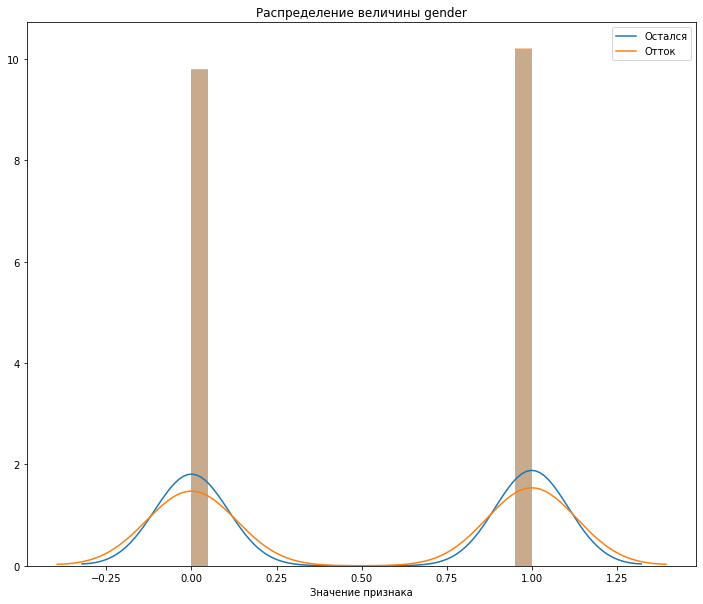

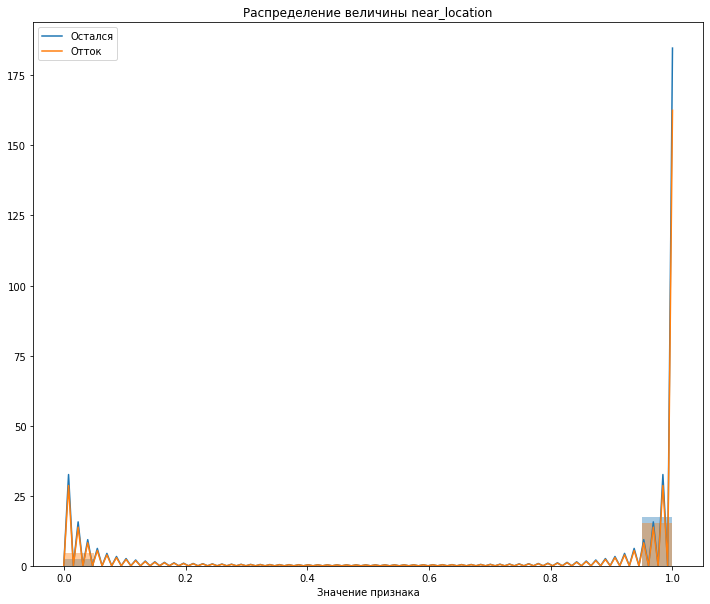

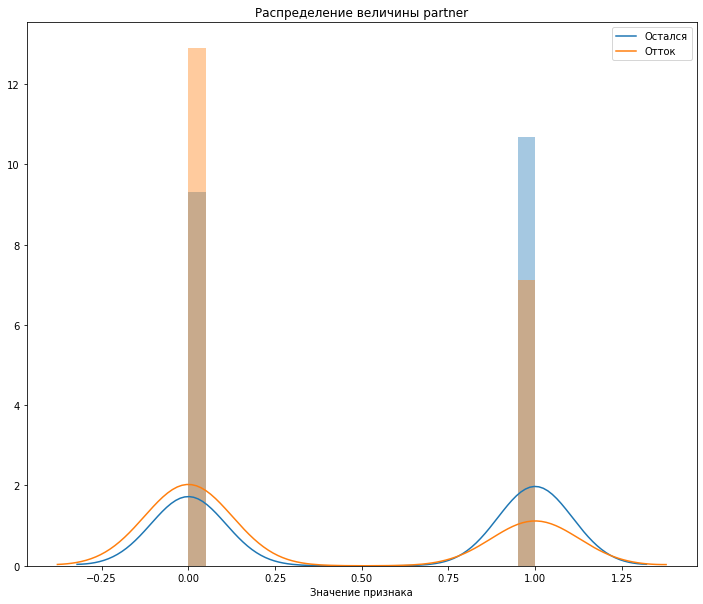

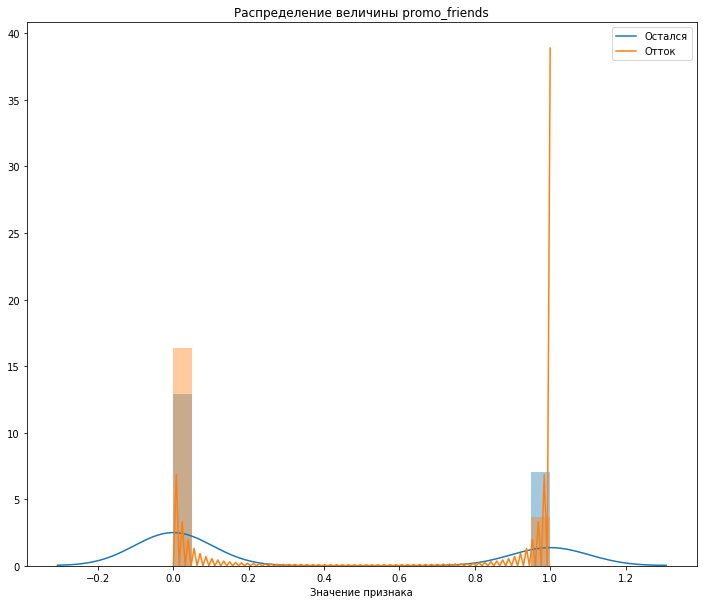

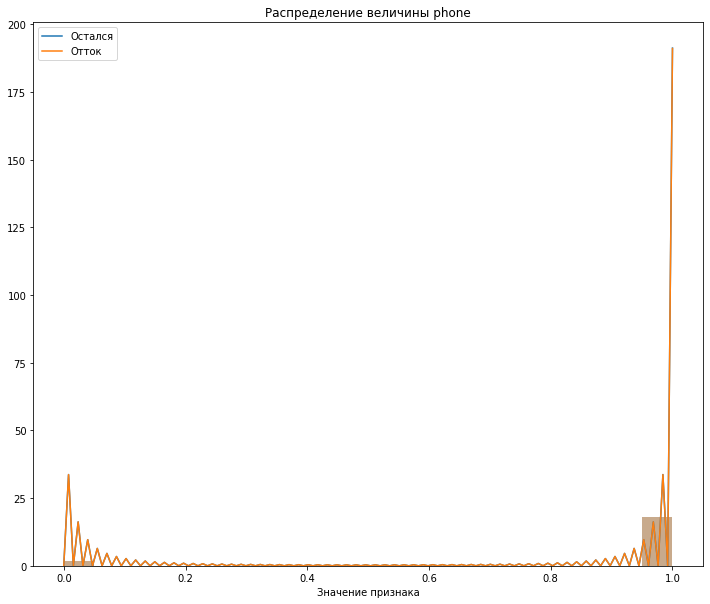

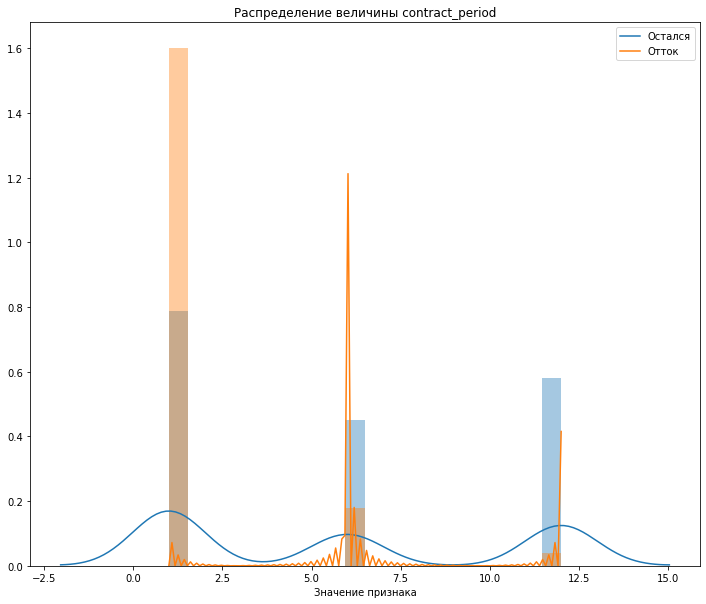

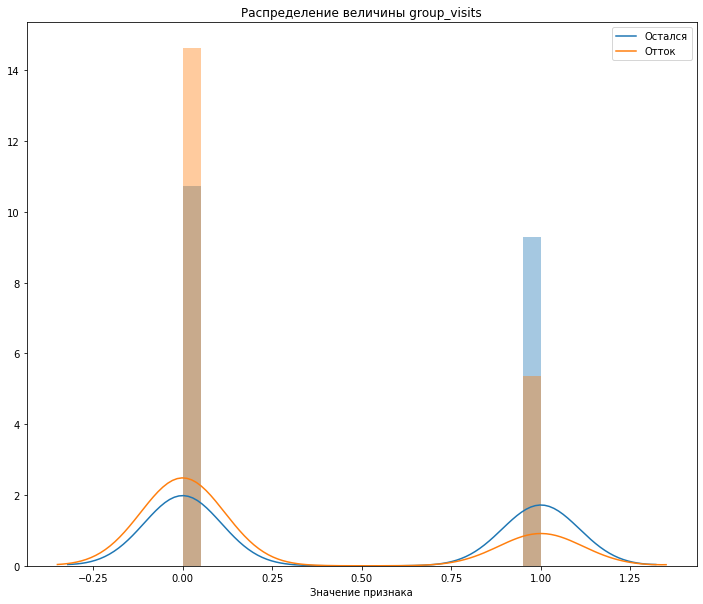

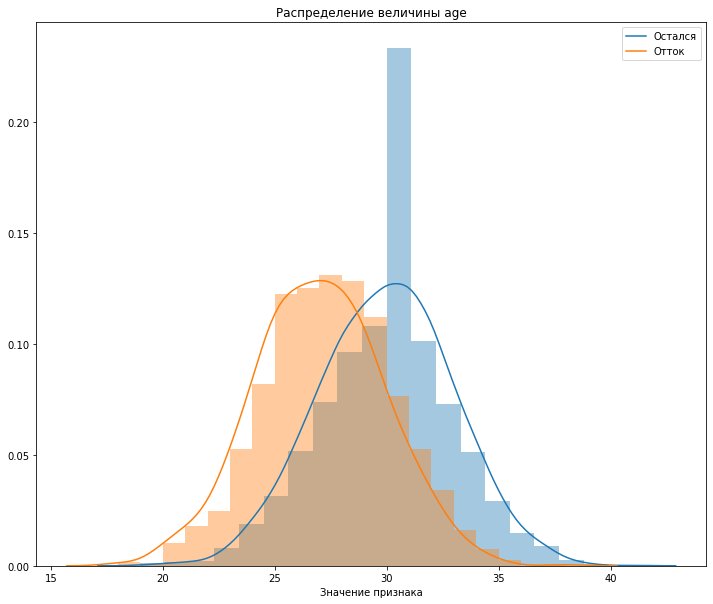

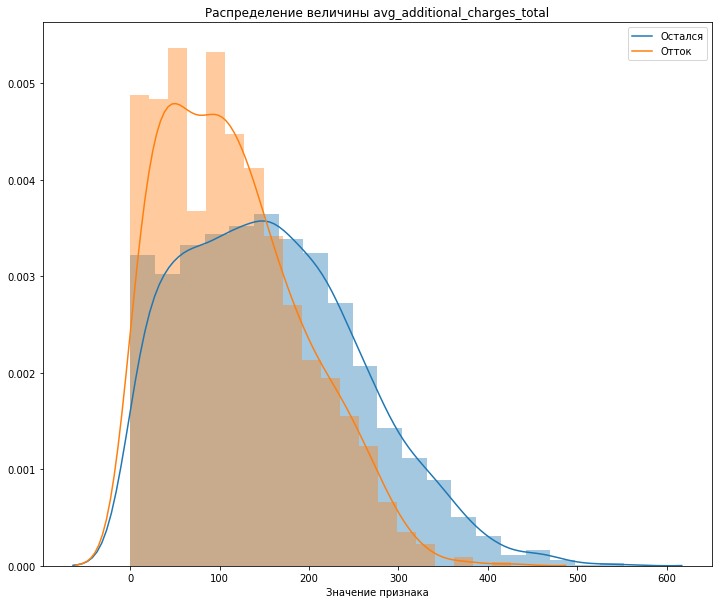

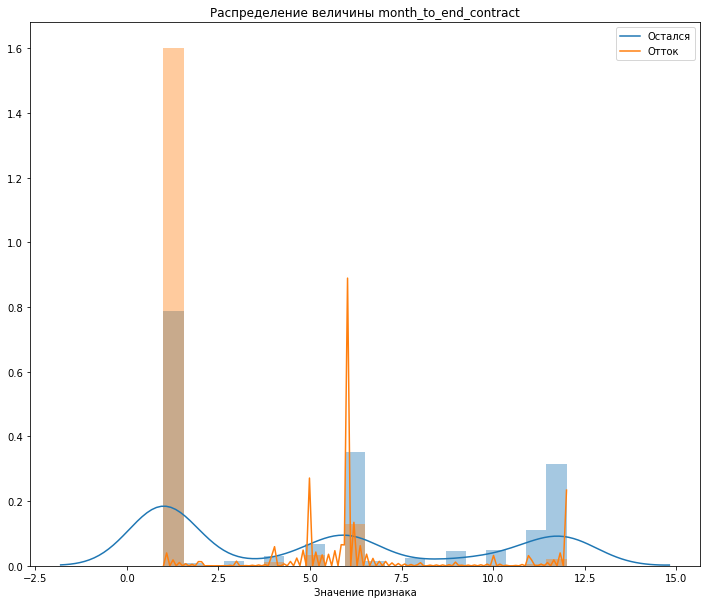

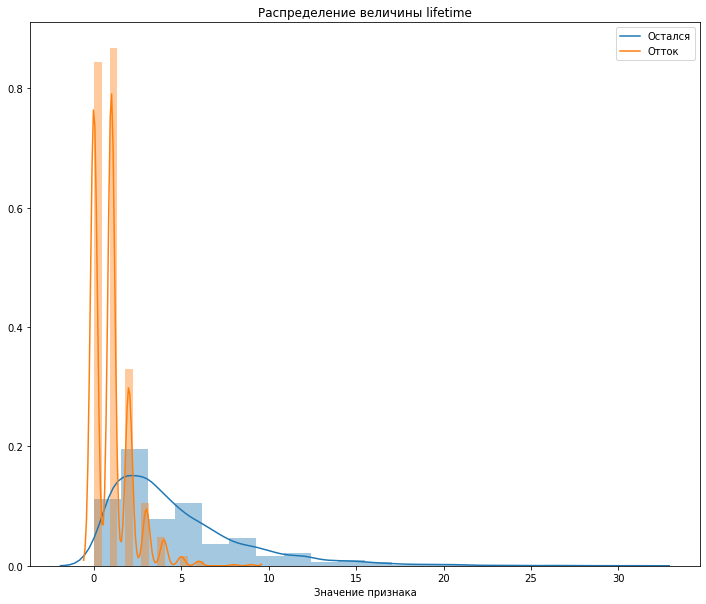

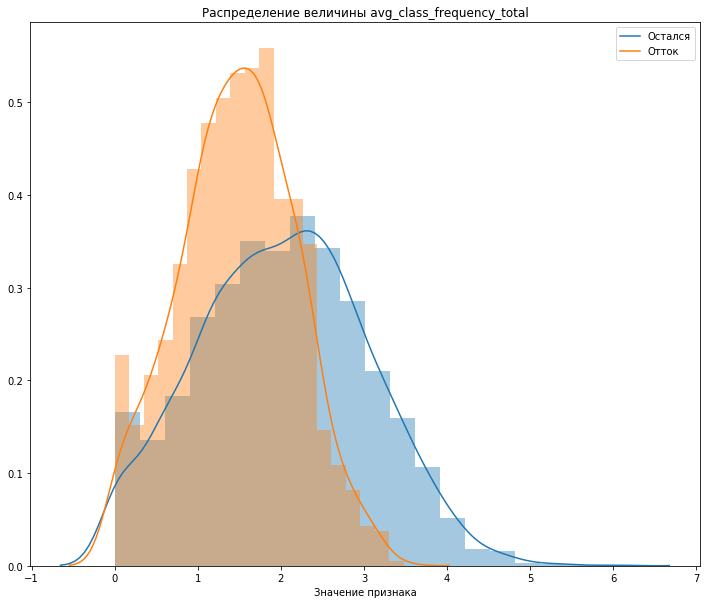

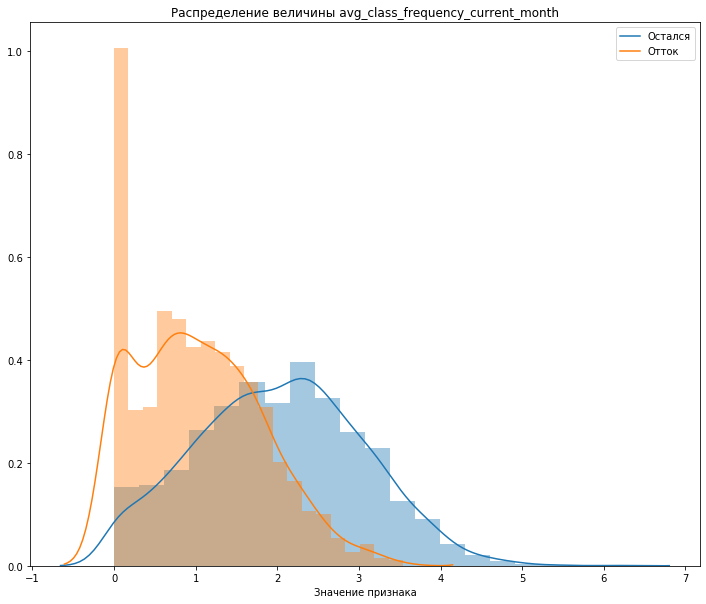

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 46em; }</style>"))

for i in churn_no.columns:
    plt.figure(figsize=(12,10))
    sns.distplot(churn_no[i], bins = 20,  kde_kws = {'label':'Остался'})
    sns.distplot(churn_yes[i], bins = 20, kde_kws = {'label':'Отток'})
    
    plt.title('Распределение величины {}'.format(i))
    plt.xlabel('Значение признака')
    plt.show()

Как видно из графиков, подтверждаются выводы, сделанные ранее по средним значениям:
* для клиентов из группы оттока характерно приобретать абонементы на 1 месяц;  
* для активных клиентов наиболее популярный срок абонемента 1 месяц, далее 12 месяцев, остальные выбирают абонементы на 6 месяцев; 
* в группе оттока клиенты редко посещают групповые занятия;  
* для фитнес-центра целевая аудитория входит в возрастной диапазон 18-41 и распределена нормально, однако, при изучении групп оттока и активных клиентов наблюдается смещение в возрастном диапазоне: в отток попадают клиенты 25-29 лет в среднем, а основная аудитория активных клиентов сосредоточена в диапазоне 28-32 лет/года;
* выручка от покупки дополнительных услуг для клиентов обеих групп распределена относительно нормально, в среднем клиенты оттока тратят на 40-50 у.е. меньше, чем более активные пользователи;  
* интересно наблюдать за параметром `lifetime` в группе клиентов оттока: пик на нулевом lifetime скорее всего говорит о том, что клиенты, которые приобрели абонемент на 1 месяц, не стали его продлять далее, далее самый высокий пик наблюдается для 1 месяца после первого посещения — эти клиенты изначально могли приобрести абонементы на 6/12 месяцев и перестать ходить в фитнес-центр на второй месяц, начиная с третьего месяца отток клиентов сильно снижается.  

### Матрица корреляции признаков

Построем матрицу корреляций и отобразим её.

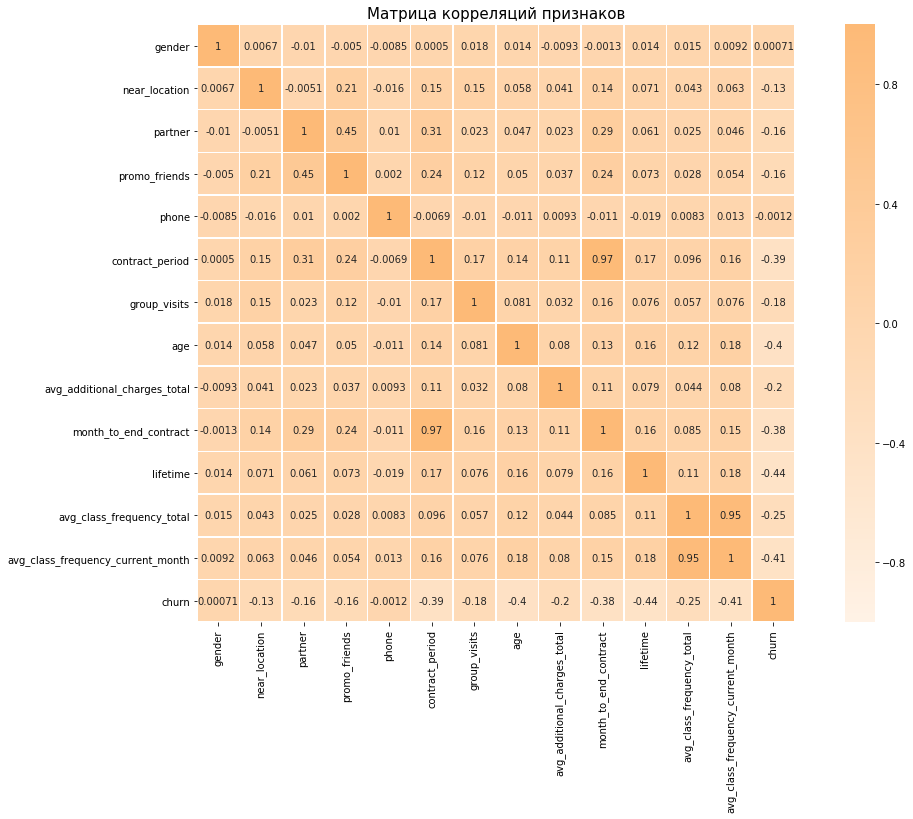

In [10]:
# сохраним матрицу корреляций в переменную cm
cm = fitness_data.corr()

# тепловая карта
cmap = sns.light_palette('#fdba77', as_cmap=True)
plt.figure(figsize=(18,11))

sns.heatmap(cm, center=0, annot=True, linewidths=.5, cmap=cmap, vmin=-1, vmax=1, square=True)

plt.title('Матрица корреляций признаков', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

По матрице корреляций признаков мы видим сильную прямую зависимость между двумя парами параметров:  
* между `month_to_end_contract` и `contract_period` корреляция 0.97;  
* между `avg_class_frequency_total` и `avg_class_frequency_current_month` корреляция 0.95.

## Построение модели прогнозирования оттока клиентов. <a id="step4"></a>    

### Модель бинарной классификации клиентов

Разобьем выборку на обучающую и валидационную для построения бинарной модели классификации клиентов (обучение с учителем методом логической регрессии `sklearn.linear_model.LogisticRegression()` и методом случайного леса `RandomForestClassifier()`) для прогноза факта оттока в следующем месяце (целевой признак).  
  
Так как в нашем кейсе задача спрогнозировать факт оттока для каждого клиента в перспективе 1 месяца, а данные не привязаны к временным рядам, для разделения выборки воспользуемся методом `train_test_split()`, а также стандартизируем значения признаков методом `StandardScaler()` для корректной работы моделей.

В первом варианте модели мы вручную удаляли один из признаков с сильной корреляцией. Такая модель показала метрики хужи, чем модель со всеми признаками.

In [11]:
fitness_data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [12]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
#X = fitness_data.drop(columns=['churn', 'month_to_end_contract', 'avg_class_frequency_total'])
X = fitness_data.drop(columns=['churn'])
y = fitness_data['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) #обучим scaler и одновременно трансформируем матрицу для обучающей выборки

# применим стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# зададим список моделей
models = [LogisticRegression(solver='liblinear'), RandomForestClassifier()]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probas = model.predict_proba(X_test)[:,1] 
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} ROC_AUC:{:.2f}'\
          .format(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred), roc_auc_score(y_test, y_probas)))

# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(m=i, X_train=X_train_st, y_train=y_train, X_test=X_test_st, y_test=y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:0.94 Precision:0.90 Recall:0.85 ROC_AUC:0.98
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy:0.90 Precision:0.85 Recall:0.76 ROC_AUC:0.96


### Выводы

Метрика доли правильных ответов **Accuracy** для логистической регрессии составляет 0.94, для метода случайного леса - 0.91. Однако, эта метрика хорошо работает при условии баланса классов, а в нашей выборке наблюдается явный перекос в пользу класса активных клиентов — их около 73%.

Метрика точности **Precision** описывает долю правильных ответов только среди целевого класса (1). По данной метрике модель логической регрессии сработала более эффективно 0.90 против 0.87 в модели случайного леса. 

Метрика полноты **Recall** описывает долю объектов положительного класса из всех объектов положительного класса, которую нашел алгоритм. По данной метрике себя лучше показала модель логической регрессии — 0.85 против показателя 0.77 у модели случайного леса. 

Метрика **AUC-ROC** (площадь под кривой ошибок) позволяет оценить качество алгоритма в целом и чем меньше ошибок он допускает, тем ближе этот показатель к 1. Модель, построенная на алгоритме логической регрессии, показывает результат выше — 0.98, чем модель случайного леса - 0.96.

На основании метрик **Recall**, **AUC-ROC** **рекомендуем использовать для прогноза оттока клиентов модель логической регрессии `LogisticRegression`.**

## Кластеризация клиентов. <a id="step5"></a>    

### Определение оптимального количества кластеров 

Для определения оптимального количества кластеров воспользуемся ранее созданной таблицей с признаками `X` и стандартизируем ее без разделения на выборки. Воспользуемся методами `linkage()` для построения матрицы расстояний и `dendrogram()` для отрисовки дендрограммы.

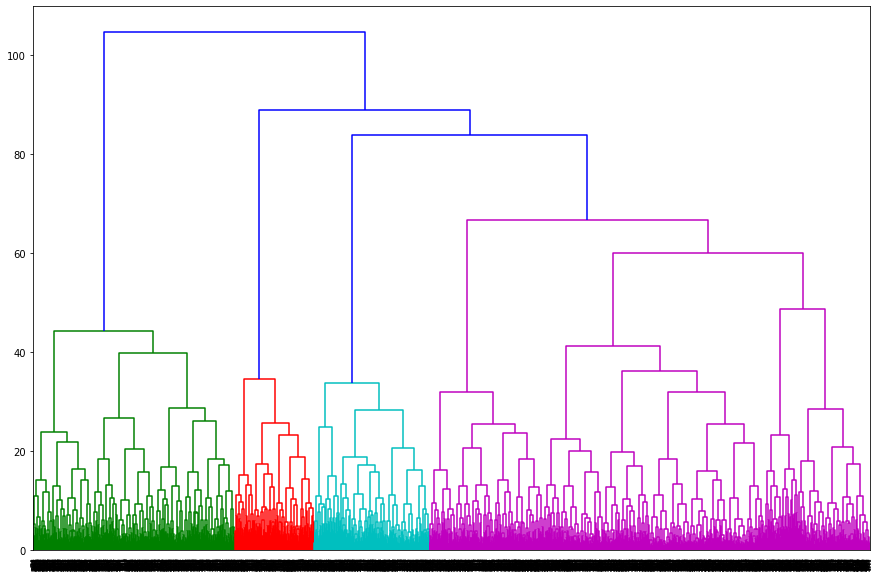

In [13]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Визуализация "связок" между объектами из переменной `linked` на дендрограмме позволяет оценить оптимальное количество кластеров для дальнейшей работы с алгоритмами кластеризации. Автоматически оптимальное кол-во определено — 4 (количество цветов на дендрограмме). Далее будем работать с алгоритмом кластеризации K-Means и зададим ему параметр `n=5` для разделения клиентов на 5 кластеров (по условиям проекта).

### Модель кластеризации (алгоритм K-Means)

Проведем кластеризацию клиентов.

In [14]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# посчитаем метрику силуэта для кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


In [15]:
# сохраним метки кластера в поле нашего датасета
fitness_data['cluster'] = labels

Посмотрим на средние значения признаков для кластеров.

In [16]:
fitness_data_groupd = fitness_data.groupby('cluster').mean().reset_index()
fitness_data_groupd.head()

,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


На первый вгляд можно выделить следующие особенности клиентов в кластерах:

* кластер 0 - клиенты живут или работают рядом с фитнесс-центром, наиболее активно участвуют в партнерских программах, у них длинные абонементы, они долго посящают фитнесс-центр и тратят деньги на дополнительные услуги;

* кластер 1 - клиенты живут или работают рядом с фитнесс-центром, покупают длительные абонементы, не оставили своего номера телефона;

* кластер 2 - клиенты, которые не живут и не работают рядом с фитнесс-центром, не пришли по акции "приведи друга", редко посещают групповые занятия; 

* кластер 3 - клиенты живут или работают рядом с фитнесс-центром, тратят на дополнительные услуги меньше всего, реже всех посещают фитнесс-центр;

* кластер 4 - клиенты живут или работают рядом с фитнесс-центром, тратят на дополнительные услуги больше всего, чаще всего посещают фитнесс - центр.

Построим распределения признаков для кластеров.

In [17]:
list_1 = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits',\
          'month_to_end_contract', 'lifetime', 'churn']
list_2 = ['age', 'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

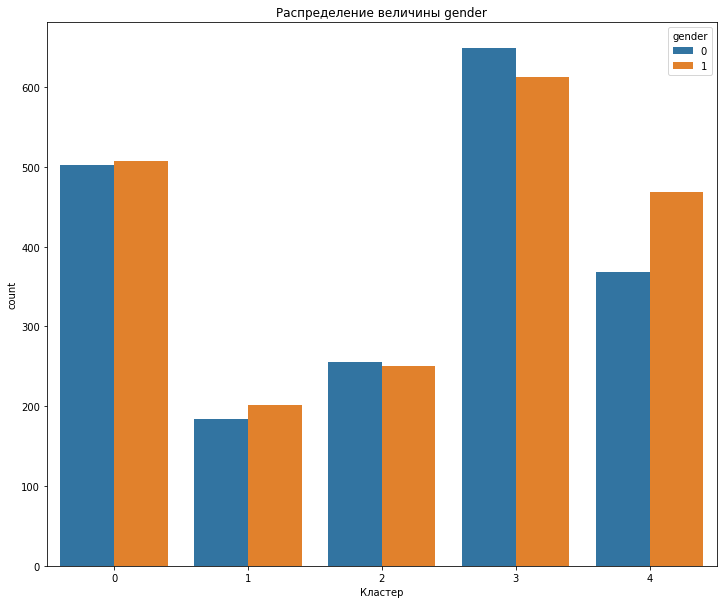

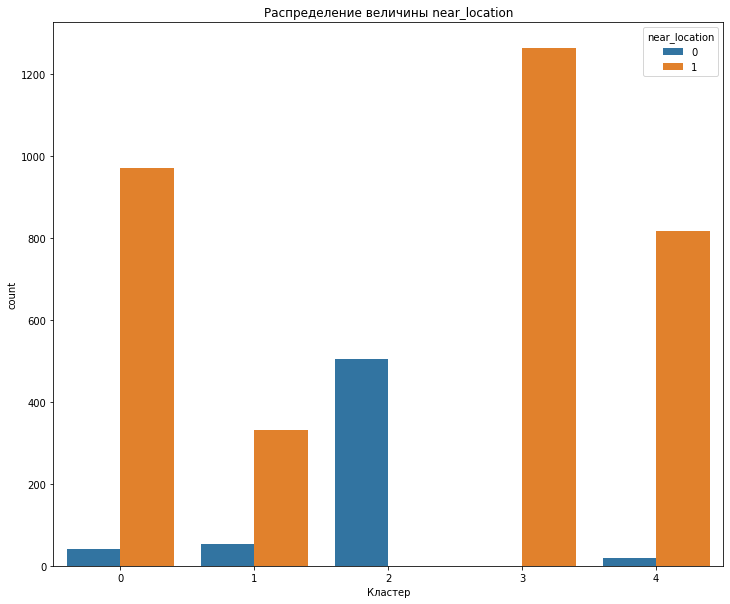

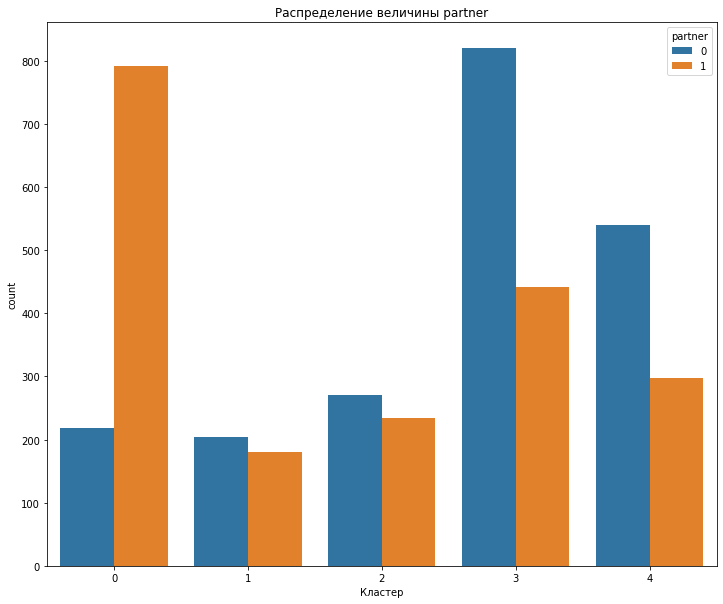

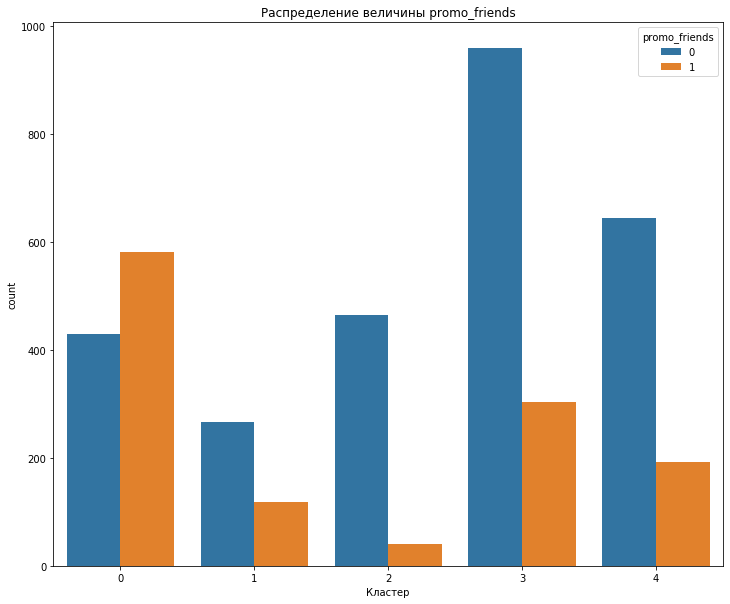

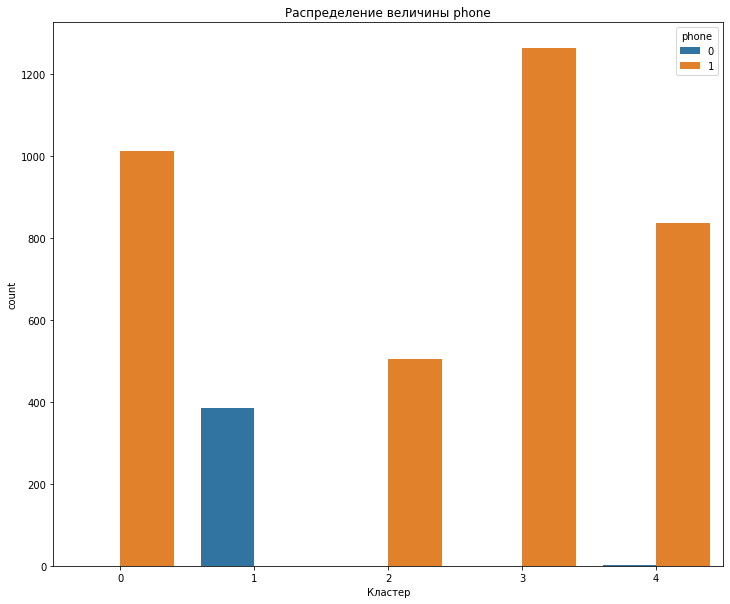

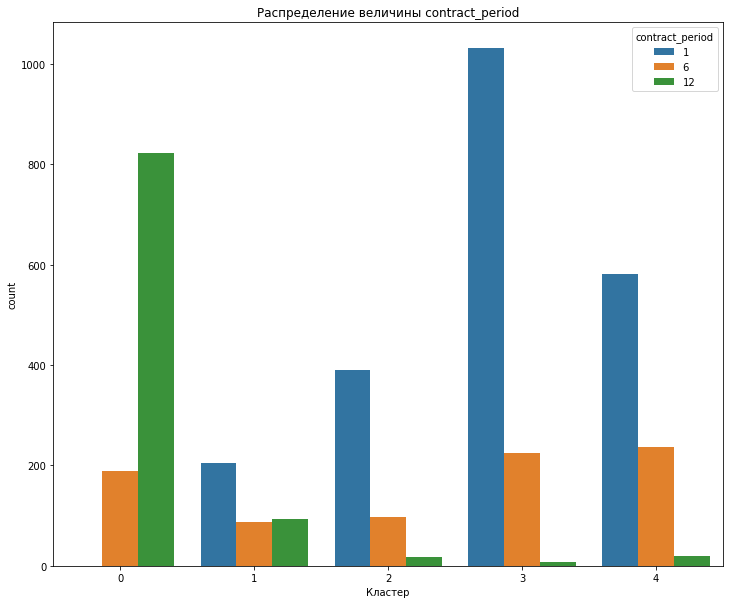

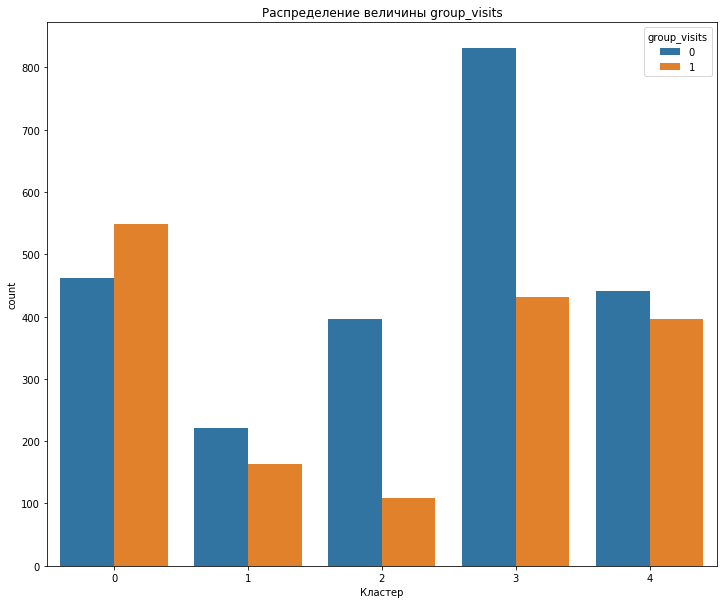

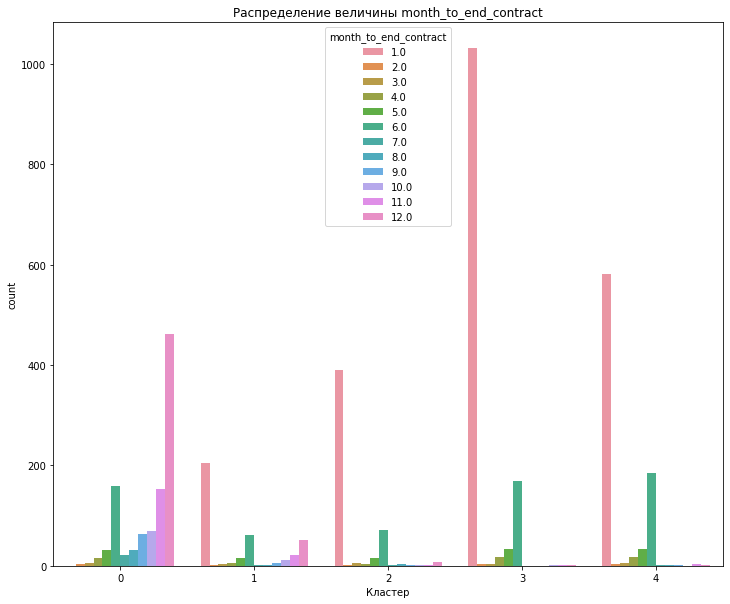

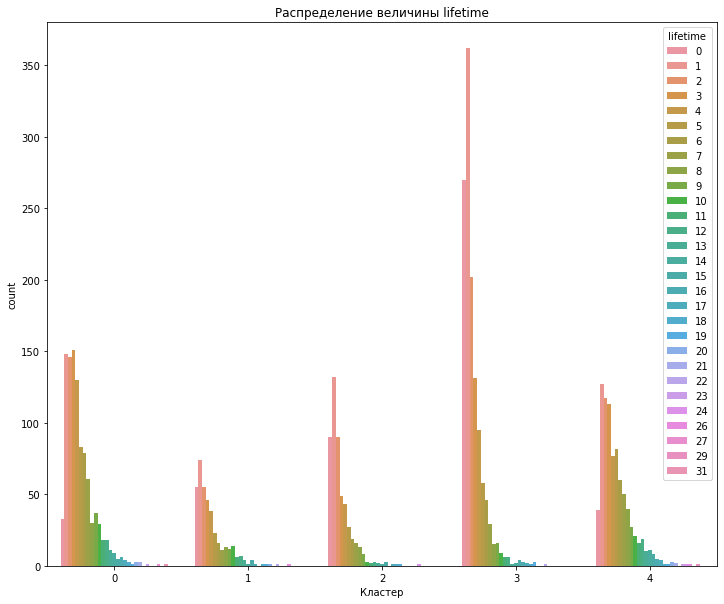

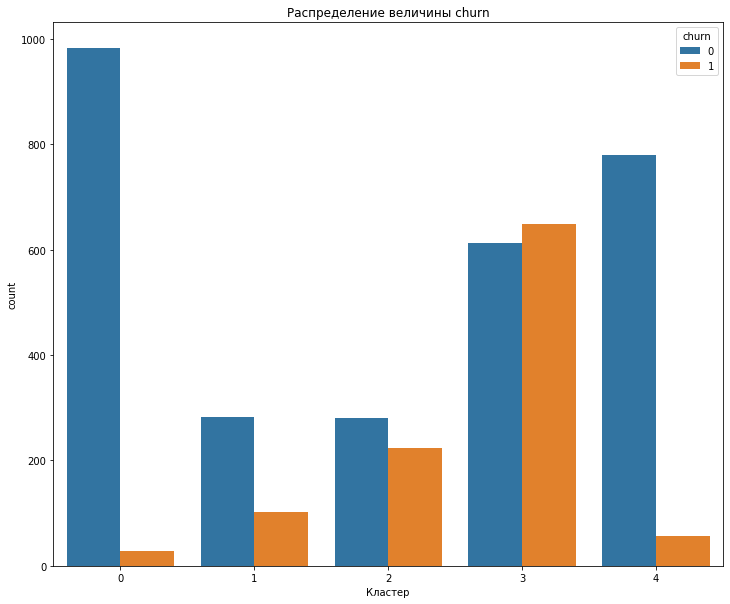

In [18]:
for i in list_1:
    plt.figure(figsize=(12,10))
    sns.countplot(data = fitness_data, x = 'cluster', hue = i)
    
    plt.title('Распределение величины {}'.format(i))
    plt.xlabel('Кластер')
    plt.show()

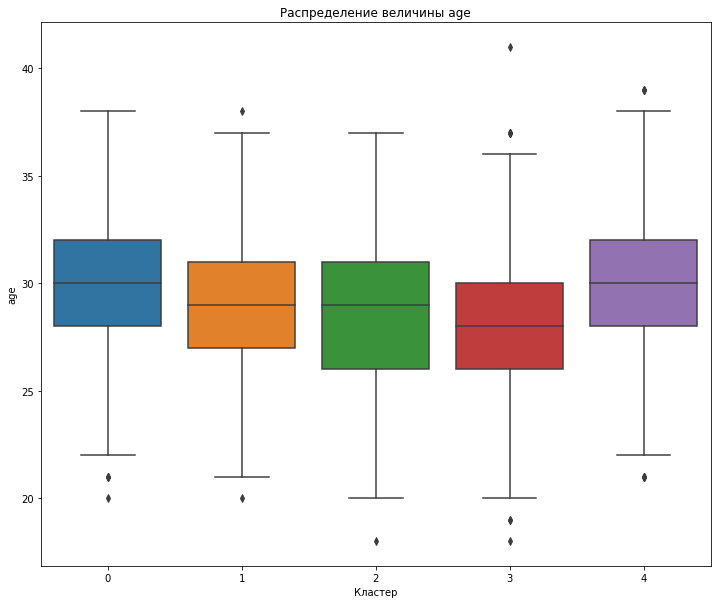

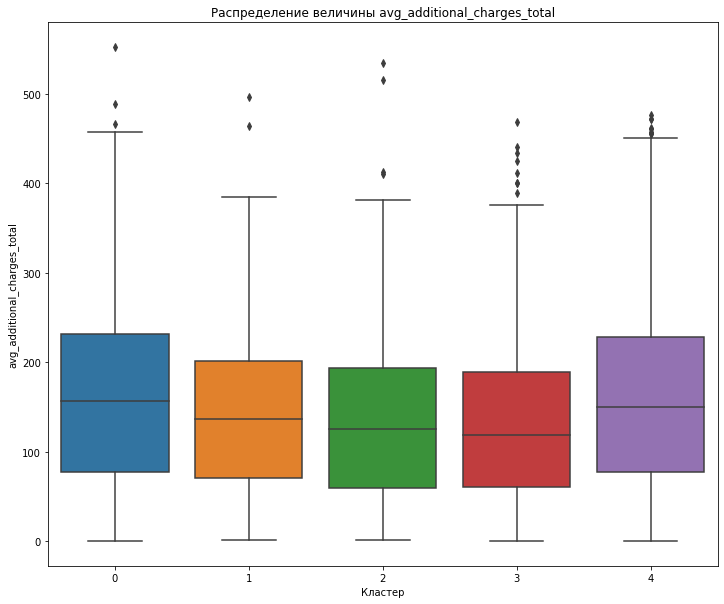

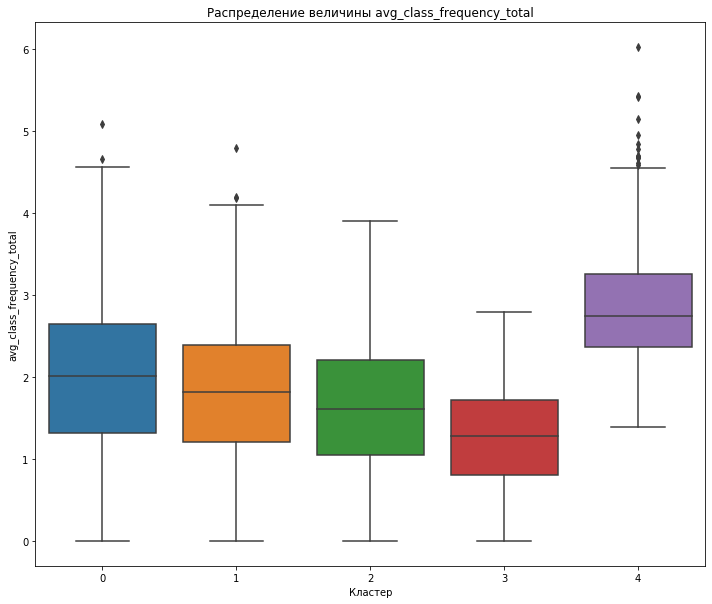

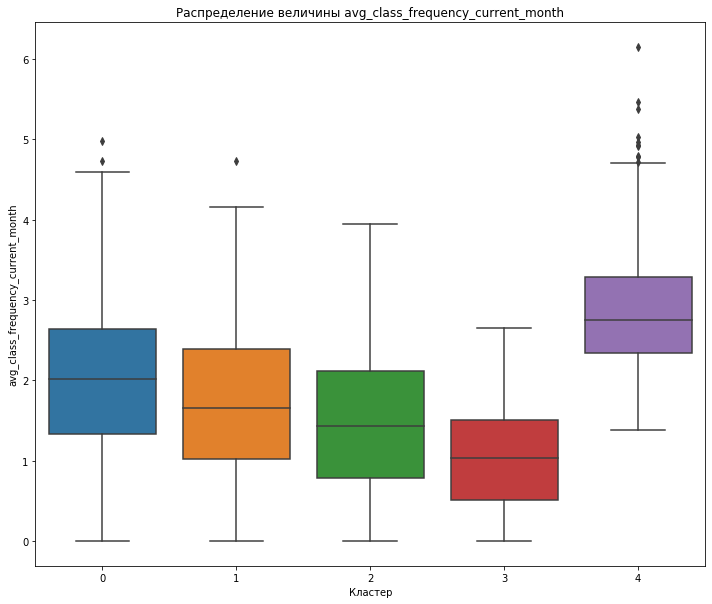

In [19]:
for i in list_2:
    plt.figure(figsize=(12,10))
    sns.boxplot(x ='cluster', y = i, data = fitness_data)
    
    plt.title('Распределение величины {}'.format(i))
    plt.xlabel('Кластер')
    plt.show()

Для каждого полученного кластера посчитайем долю оттока.

In [21]:
part_of_churn = fitness_data.groupby('cluster')['churn'].sum()/fitness_data.groupby('cluster')['churn'].count()*100
part_of_churn

cluster
0     2.769535
1    26.753247
2    44.356436
3    51.426307
4     6.810036
Name: churn, dtype: float64

### Выводы

**Кластер 0:**  
- лояльные клиенты (доля оттока 2,8%);
- живут или работают рядом с фитнесс-центром;
- активно пользуются услугами фитнес-центра; 
- потенциальный "премиум" сегмент;
- участники партнерских и акционных программ;  
- посещают групповые занятия;  
- основная масса клиентов - за 30 лет;  
- предпочитают приобретать абонементы на длительный срок (6, 12 месяцев);  
- готовы платить за дополнительные услуги. 

**Кластер 1:**  
- средний процент оттока (26,8%);  
- живут или работают рядом с фитнесс-центром;  
- редко участвуют в акциях;  
- предпочитают краткосрочные абонементы, но могут купить и на длительный срок (6, 12 месяцев); 
- средний возраст 29 лет;  
- редко посещают групповые программы.

**Кластер 2:**  
- высокий процент оттока (44,4%), зона риска;  
- не живут и не работают рядом с фитнесс-центром;  
- не участвуют в акциях;
- редко посещают групповые занятия;
- предпочитают краткосрочные абонементы (на 1 месяц);  
- средний возраст 28 лет;  
- не готовы платить за дополнительные услуги.

**Кластер 3:**  
- высокий процент оттока (51,4%);  
- живут или работают рядом с фитнесс-центром;  
- редко участвуют в акциях и партнерских программах;
- не готовы платить за дополнительные услуги;
- наименее активно пользуются услугами фитнесс-центра;
- предпочитают краткосрочные абонементы (на 1 месяц);  
- основная масса клиентов - до 30 лет.

**Кластер 4:**  
- лояльные клиенты (доля оттока 6,8%);  
- средний возраст 30 лет;   
- готовы пользоваться услугами фитнес-центра, самые высокие средние показатели дополнительных покупок;  
- потенциальный "премиум" сегмент;  
- активнее всех посещают фитнесс-центр;  
- редко участвуют в партнерских и реферальных программах;  
- предпочитают краткосрочные абонементы (на 1 месяц);  
- посещают групповые занятия. 

## Выводы и рекомендации. <a id="step6"></a>    

**Выводы:**
* В ходе работы были построены модели логистической регресии и случайного леса, которые позволяют спрогнозировать вероятность оттока каджого клиента сети фитнес-центров. На основании метрик Recall, AUC-ROC рекомендуем использовать для прогноза оттока клиентов модель логической регрессии `LogisticRegression`;
* Проведена кластеризация пользователей, выделено 5 основных кластеров. Для каждого кластера описан потрет пользователя.

**Рекомендации по улучшению качества работы с клиентами:**  
* Клиенты уходят после первого месяца посещения фитнес-центра. Большой отток на начальном этапе указывает на то, что клиент не успевает втянуться в процесс регулярных занятий. Возможно, стоит продумать механизм поддержки "новичков" и дополнительные стимулирующие меры, например, предложить таким клиентам скидки на персональных тренеров или несколько бесплатных персональных занятий. Так же можно добавить в расписание групповых занятий больше тренировок именно начального уровня, чтобы новые клиенты чувствовали себя на них комфортно. 
* Есть ряд клиентов, которые проживают и работают на достаточном удалении от их текущего фитнес-центра, это неудобство отягощает их посещения и они в итоге уходят. Для таких клиентов рекомендуется искать варианты посещения других фитнес-центров сети, которые будут для них географически удобны.
* Сосредоточить личное внимание менеджеров на кластерах 0, 4, так как здесь прослеживается "премиум" сегмент: допродажа дорогих дополнительных услуг, бонусы для поддержания лояльности, индивидуальный подход.  